# Lipid story for GBM

This notebook creates a list of lipid metabolism related genes by taking all proteins and comparing their abundance by grouping by Mesenchymal/ Normal and Mesenchymal/Proneural. The common genes between the two t-test were then searched to see if they were in Uniprot's list of genes related to Lipid metabolism 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u


In [2]:
#cptac.download(dataset='ccrcc', version='0.0')
brain= cptac.Gbm()
desired_cutoff = 0.05
gene = 'RB1'

In [3]:
#join clinical and proteomic data
clin_and_prot = brain.join_metadata_to_omics(metadata_df_name="clinical", omics_df_name="proteomics")
clin_and_prot = clin_and_prot.rename(columns = {"Patient_ID": "case"})


In [4]:
#Read in files with TCGA subtypes
subtypes = pd.read_csv("/Users/Lindsey/Downloads/gbm_all_subtype_collections.2019-11-13.tsv", sep= "\t")

case_subtype = subtypes[["case",'rna_wang_cancer_cell_2017']] #only need subtype and case
case_subtype = case_subtype.rename(columns = {"rna_wang_cancer_cell_2017": "TCGA_subtype"})


subtypes.head()


,case,sample_type,nmf_consensus,nmf_cluster_membership,rna_wang_cancer_cell_2017,mRNA_stemness_index,dna_methyl,is_gcimp,immune,telomere,lipid,mirna,ancestry_prediction,ancestry_prediction_afr_prob,ancestry_prediction_amr_prob,ancestry_prediction_eas_prob,ancestry_prediction_eur_prob,ancestry_prediction_sas_prob,wxs_total_mutation,wgs_total_mutation
0,C3L-00104,tumor,nmf1,0.743,Proneural,0.678244,dm2,True,low,normal,NaN,mi5,EUR,0.00,0.03,0.00,0.97,0.00,60.0,2632.0
1,C3L-00365,tumor,nmf3,0.614,Classical,0.681122,dm4,False,low,normal,TAG_enriched,mi1,EUR,0.00,0.02,0.00,0.98,0.00,57.0,7628.0
2,C3L-00674,tumor,nmf1,0.507,Mesenchymal,0.744635,dm5,False,high,normal,TAG_enriched,mi3,EUR,0.01,0.00,0.01,0.98,0.00,37.0,1233.0
3,C3L-00677,tumor,nmf1,0.536,Proneural,0.900896,dm5,False,low,long,TAG_enriched,mi5,EUR,0.02,0.11,0.00,0.85,0.02,925.0,16955.0
4,C3L-01040,tumor,nmf1,0.589,Classical,0.647288,dm5,False,low,normal,NaN,mi1,EUR,0.00,0.03,0.00,0.97,0.00,85.0,4298.0


In [5]:
case_subtype = case_subtype.replace(np.nan, 'Normal', regex=True)
case_subtype = case_subtype.set_index("case")

case_subtype


,TCGA_subtype
case,
C3L-00104,Proneural
C3L-00365,Classical
C3L-00674,Mesenchymal
C3L-00677,Proneural
C3L-01040,Classical
...,...
PT-RN5K,Normal
PT-RU72,Normal
PT-UTHO,Normal


In [6]:
# merge tgca subtypes with proteomics and clincal df
prot_subtype= clin_and_prot.merge(case_subtype, on='case')

prot_subtype = prot_subtype.set_index("case")


# Mesenchymal VS Normal

In [7]:
#create mesenchymal and normal only df
Mesenchymal = (prot_subtype.loc[prot_subtype['TCGA_subtype'] == 'Mesenchymal'])
Normal = (prot_subtype.loc[prot_subtype['Sample_Tumor_Normal'] == 'Normal'])
Normal.head()

,Sample_Tumor_Normal,age,gender,height,weight,bmi,country_of_origin,race,ethnicity,ethnicity_self_identify,...,ZSWIM8_proteomics,ZW10_proteomics,ZWILCH_proteomics,ZWINT_proteomics,ZXDC_proteomics,ZYG11B_proteomics,ZYX_proteomics,ZZEF1_proteomics,ZZZ3_proteomics,TCGA_subtype
case,,,,,,,,,,,,,,,,,,,,,
PT-NPJ7,Normal,68.0,Female,160.02,74.84,29.23,NaN,White,NaN,NaN,...,0.337310,0.019538,-1.375146,NaN,0.164100,0.767921,-1.128100,0.209480,-0.205739,Normal
PT-P44H,Normal,43.0,Male,177.80,112.04,35.44,NaN,White,NaN,NaN,...,0.335445,-0.199247,-0.798595,NaN,0.517515,0.379683,-1.087567,0.210812,-0.176034,Normal
PT-Q2AG,Normal,42.0,Female,177.80,102.06,32.28,NaN,White,NaN,NaN,...,0.252516,-0.102542,NaN,NaN,NaN,0.791386,-0.667928,0.053734,-0.229870,Normal
PT-QVJO,Normal,64.0,Female,170.18,55.79,19.26,NaN,White,Not Hispanic or Latino,NaN,...,0.320193,-0.098267,-1.321314,NaN,-1.330917,0.667393,-1.172195,0.303740,-0.556137,Normal
PT-R55F,Normal,55.0,Male,177.80,77.11,24.39,NaN,White,Not Hispanic or Latino,NaN,...,0.326426,-0.109841,-0.676704,NaN,0.080553,0.563370,-0.973314,0.478914,-0.415546,Normal


In [8]:
# create mesenchymal and normal df 
Mesench_Normal = Mesenchymal.append(Normal)
Mesench_Normal.drop(Mesench_Normal.iloc[:, :28], axis=1, inplace=True)


In [9]:
#create gene list for t-test
prot_col_list = list(Mesench_Normal.columns)
prot_col_list.remove('TCGA_subtype')


In [10]:
#Call wrap_ttest, pass in formatted dataframe

prot_all_comparisons = u.wrap_ttest(Mesench_Normal, 'TCGA_subtype', prot_col_list)
prot_num_comparisons = len(prot_col_list)
print("Number of comparisons:", prot_num_comparisons)
prot_bonferroni_cutoff = .05 / prot_num_comparisons
print("Bonferroni cutoff = ", prot_bonferroni_cutoff)
print("Logged Bonferroni cutoff = ", np.log10(prot_bonferroni_cutoff))


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5291 significant comparisons!
Number of comparisons: 11140
Bonferroni cutoff =  4.4883303411131066e-06
Logged Bonferroni cutoff =  -5.347915186501691


In [11]:
#print significant comparisons 
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= prot_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons), '\n')

if len(prot_sig_comparisons) > 0:
    print(prot_sig_comparisons)

prot_sig_comparisons_Mesench_Normal = prot_sig_comparisons

Number of significant Proteomics comparisons:  5291 

               Comparison       P_Value
0        PI4KA_proteomics  1.106746e-35
1         WDR7_proteomics  2.413637e-33
2       ANKS1B_proteomics  4.412780e-33
3        DMXL2_proteomics  1.011996e-32
4         MADD_proteomics  2.561057e-32
...                   ...           ...
5286  C12orf73_proteomics  4.344286e-06
5287     KDM4A_proteomics  4.350479e-06
5288      AGO2_proteomics  4.353342e-06
5289    ZNF618_proteomics  4.381527e-06
5290     CYTH4_proteomics  4.432903e-06

[5291 rows x 2 columns]


In [12]:
prot_sig_comparisons_Mesench_Normal.set_index("Comparison")
prot_sig_comparisons_Mesench_Normal = prot_sig_comparisons_Mesench_Normal.rename(columns = {"P_Value": "P_Value_MN"})
prot_sig_comparisons_Mesench_Normal

,Comparison,P_Value_MN
0,PI4KA_proteomics,1.106746e-35
1,WDR7_proteomics,2.413637e-33
2,ANKS1B_proteomics,4.412780e-33
3,DMXL2_proteomics,1.011996e-32
4,MADD_proteomics,2.561057e-32
...,...,...
5286,C12orf73_proteomics,4.344286e-06
5287,KDM4A_proteomics,4.350479e-06
5288,AGO2_proteomics,4.353342e-06
5289,ZNF618_proteomics,4.381527e-06


# Mesenchymal and Proneural

In [13]:
#create df that are only Mesenchymal and Proneural 
Mesenchymal = (prot_subtype.loc[prot_subtype['TCGA_subtype'] == 'Mesenchymal'])
Proneural = (prot_subtype.loc[prot_subtype['TCGA_subtype'] == 'Proneural'])


In [14]:
#create Mesenchymal and Proneural df 
Mesench_Proneural = Mesenchymal.append(Proneural)
Mesench_Proneural.drop(Mesench_Proneural.iloc[:, :28], axis=1, inplace=True)



In [15]:
#create list of genes to pass into t-test
prot_col_list = list(Mesench_Proneural.columns)
prot_col_list.remove('TCGA_subtype')



In [16]:
#Call wrap_ttest, pass in formatted dataframe

prot_all_comparisons = u.wrap_ttest(Mesench_Proneural, 'TCGA_subtype', prot_col_list)
prot_num_comparisons = len(prot_col_list)
print("Number of comparisons:", prot_num_comparisons)
prot_bonferroni_cutoff = .05 / prot_num_comparisons
print("Bonferroni cutoff = ", prot_bonferroni_cutoff)
print("Logged Bonferroni cutoff = ", np.log10(prot_bonferroni_cutoff))

961 significant comparisons!
Number of comparisons: 11140
Bonferroni cutoff =  4.4883303411131066e-06
Logged Bonferroni cutoff =  -5.347915186501691


In [17]:
#Print significant comparisons 
prot_all_comparisons = prot_all_comparisons.dropna(axis=0)
prot_sig_comparisons = prot_all_comparisons.loc[prot_all_comparisons['P_Value'] <= prot_bonferroni_cutoff]
print("Number of significant Proteomics comparisons: ", len(prot_sig_comparisons), '\n')

if len(prot_sig_comparisons) > 0:
    print(prot_sig_comparisons)
    
prot_sig_comparisons_Mesench_Proneural = prot_sig_comparisons

Number of significant Proteomics comparisons:  961 

             Comparison       P_Value
0     PODXL2_proteomics  2.047362e-14
1      BASP1_proteomics  2.654212e-14
2     GPRIN1_proteomics  7.094843e-14
3      PHF24_proteomics  7.994311e-14
4       SCAI_proteomics  1.492919e-13
..                  ...           ...
956  CNTNAP1_proteomics  4.392254e-06
957    HSPB1_proteomics  4.421559e-06
958    NOVA1_proteomics  4.426351e-06
959   THSD7A_proteomics  4.466200e-06
960   PARP14_proteomics  4.483369e-06

[961 rows x 2 columns]


In [18]:
prot_sig_comparisons_Mesench_Proneural.set_index("Comparison")
prot_sig_comparisons_Mesench_Proneural = prot_sig_comparisons_Mesench_Proneural.rename(columns = {"P_Value": "P_Value_MP"})
prot_sig_comparisons_Mesench_Proneural

,Comparison,P_Value_MP
0,PODXL2_proteomics,2.047362e-14
1,BASP1_proteomics,2.654212e-14
2,GPRIN1_proteomics,7.094843e-14
3,PHF24_proteomics,7.994311e-14
4,SCAI_proteomics,1.492919e-13
...,...,...
956,CNTNAP1_proteomics,4.392254e-06
957,HSPB1_proteomics,4.421559e-06
958,NOVA1_proteomics,4.426351e-06
959,THSD7A_proteomics,4.466200e-06


In [19]:
#create list of common significant genes
common_sig = prot_sig_comparisons_Mesench_Proneural.merge(prot_sig_comparisons_Mesench_Normal, on='Comparison')
common_sig.replace(to_replace = '_proteomics', value = '', 
                        inplace = True, regex = True)# shorten column names


sig_list  = common_sig['Comparison'] 


In [20]:
#Calculate mean
Mesenchymal["MTMR1_proteomics"].mean()


-0.20449052751586466

In [21]:
#check to see if mean is up in normal
Normal["MTMR1_proteomics"].mean()

0.9241884660140893

In [22]:
#read in uniProt file for lipid metabolism 
lipid_genes = pd.read_csv("/Users/Lindsey/Downloads/uniprot_keyword_Lipid.tab", sep= "\t")




In [23]:
# create list of significant genes (common in both t-tests) that are also in Uniprot df 
genes_dirty = list(lipid_genes['Gene names'])
genes_clean = []
for e in genes_dirty:
    bits = e.split(" ")
    genes_clean.append(bits[0])
    
 
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

winners = intersection(sig_list, genes_clean)
#print (winners)
#list from proteomics correlation
winners

['HDLBP',
 'PCYT1A',
 'PLBD1',
 'PTPRN2',
 'SULT4A1',
 'B4GALT5',
 'ACOT7',
 'SLC27A4',
 'MTMR1',
 'SMPD3',
 'PLCB1',
 'DAGLA',
 'BSCL2',
 'PLCG2']

# creating box plot

In [24]:

string = '_proteomics'
winners_prot = [x + string for x in winners]
winners_prot.append("TCGA_subtype")
winners_prot

['HDLBP_proteomics',
 'PCYT1A_proteomics',
 'PLBD1_proteomics',
 'PTPRN2_proteomics',
 'SULT4A1_proteomics',
 'B4GALT5_proteomics',
 'ACOT7_proteomics',
 'SLC27A4_proteomics',
 'MTMR1_proteomics',
 'SMPD3_proteomics',
 'PLCB1_proteomics',
 'DAGLA_proteomics',
 'BSCL2_proteomics',
 'PLCG2_proteomics',
 'TCGA_subtype']

In [25]:

Winner_df = Mesench_Normal[winners_prot]
Winner_df

,HDLBP_proteomics,PCYT1A_proteomics,PLBD1_proteomics,PTPRN2_proteomics,SULT4A1_proteomics,B4GALT5_proteomics,ACOT7_proteomics,SLC27A4_proteomics,MTMR1_proteomics,SMPD3_proteomics,PLCB1_proteomics,DAGLA_proteomics,BSCL2_proteomics,PLCG2_proteomics,TCGA_subtype
case,,,,,,,,,,,,,,,
C3L-00674,0.102850,-0.368129,1.591647,0.723717,0.642583,0.831471,0.192053,-0.232735,-0.251267,-0.064438,0.188146,-0.109865,-0.012542,0.491556,Mesenchymal
C3L-01043,0.605838,0.127797,2.093531,-0.815444,-2.036621,-0.251307,-1.018826,-0.444960,-0.379577,-0.729819,-1.627367,-0.552815,-1.068734,0.388479,Mesenchymal
C3L-01045,0.340972,0.281764,1.001953,-0.977000,-2.151065,1.158188,-0.020693,-0.491132,0.021627,-0.756212,-2.096069,-0.521383,-0.927987,-0.299536,Mesenchymal
C3L-01046,0.619897,0.049242,3.009927,-0.978918,-1.556350,0.405901,-0.605838,-0.245513,-0.273709,-0.554544,-0.770776,-0.954160,-1.012202,1.059935,Mesenchymal
C3L-01049,0.765673,0.138139,0.213798,-0.582385,-1.453385,NaN,-0.470329,-0.206257,-0.402366,-0.697258,-0.979585,-0.492760,-0.288402,-0.228468,Mesenchymal
C3L-01142,0.516808,0.451897,2.045886,-0.645316,-0.996703,0.722414,-0.303031,-0.241305,-0.505333,-1.309935,-0.571803,-1.163653,0.205669,1.171414,Mesenchymal
C3L-02465,-0.048008,-0.104229,1.035403,-0.207869,-0.289924,NaN,-0.238650,-0.129412,-0.217730,0.161027,-0.238557,0.028573,0.051000,0.612279,Mesenchymal
C3L-02704,0.014569,0.012994,0.042023,-0.156961,-0.094952,-0.192791,0.010242,0.094497,0.099255,-0.058789,-0.399312,0.436295,-0.359469,-0.105148,Mesenchymal
C3L-02705,0.059089,-0.314313,1.248329,0.213074,0.480024,0.141471,0.252811,-0.061134,-0.436229,-0.060631,-0.017794,0.034154,0.056873,0.641576,Mesenchymal


In [26]:
string = '_proteomics'
winners_prot = [x + string for x in winners]


In [27]:
Winner_df = pd.melt(Winner_df, id_vars = ['TCGA_subtype'])
Winner_df

,TCGA_subtype,variable,value
0,Mesenchymal,HDLBP_proteomics,0.102850
1,Mesenchymal,HDLBP_proteomics,0.605838
2,Mesenchymal,HDLBP_proteomics,0.340972
3,Mesenchymal,HDLBP_proteomics,0.619897
4,Mesenchymal,HDLBP_proteomics,0.765673
...,...,...,...
681,Normal,PLCG2_proteomics,-0.530040
682,Normal,PLCG2_proteomics,-0.543046
683,Normal,PLCG2_proteomics,-0.834675
684,Normal,PLCG2_proteomics,-0.727324


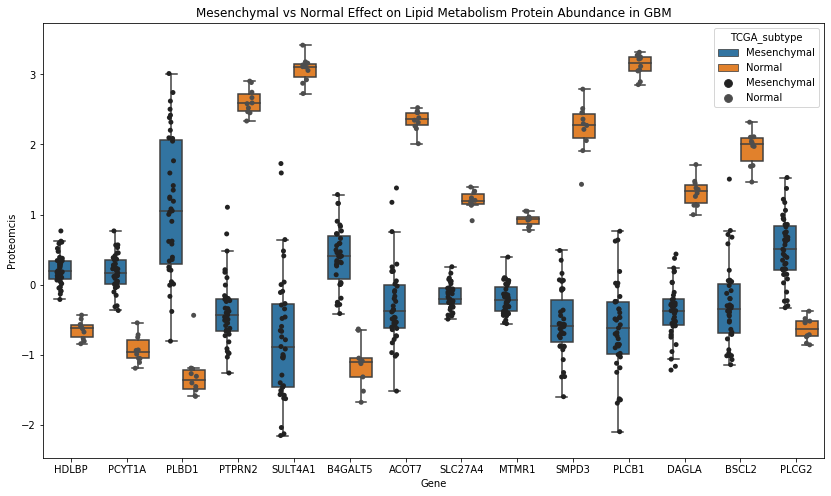

In [28]:
Winner_df.replace(to_replace = '_proteomics', value = '', 
                        inplace = True, regex = True)
# Visualize
plt.rcParams['figure.figsize']=(14,8) #size of plot
boxplot = sns.boxplot(x="variable", y="value", hue = 'TCGA_subtype', 
                         hue_order = ['Mesenchymal',"Normal"], data = Winner_df, showfliers = False)    
boxplot.set_title("Mesenchymal vs Normal Effect on Lipid Metabolism Protein Abundance in GBM")
boxplot = sns.stripplot(x="variable", y="value", hue = 'TCGA_subtype', data = Winner_df, jitter = True, 
                           color = ".3", hue_order = ["Mesenchymal","Normal"], dodge = True)
boxplot.set(xlabel = "Gene", ylabel = 'Proteomcis')


plt.show()
plt.clf()
plt.close()